In [1]:
from matplotlib import pyplot as plt
import xarray as xr
from tqdm import tqdm as progressbar
import numpy as np

import sys
sys.path.append('../McCreary')

from dynmodes import *

In [2]:
Nsq = np.load('Nsq.npy', allow_pickle=True)
depth = Nsq[1, :]
Nsq = Nsq[0, :]

In [3]:
from  multimodemodel import StaggeredGrid

nmodes = 25

c_grid = StaggeredGrid.regular_lat_lon_c_grid(
    lon_start=-50.0,
    lon_end=50.0,
    lat_start=-5.0,
    lat_end=5.0,
    nx=100 * 4 + 1,
    ny=10 * 4 + 1,
    z = np.arange(nmodes)
)

In [4]:
from multimodemodel import MultimodeParameters, f_on_sphere
multimode_params = MultimodeParameters(z=depth, Nsq=Nsq, nmodes=25, coriolis_func=f_on_sphere(omega=7.272205e-05), on_grid=c_grid)

In [5]:
ds = multimode_params.as_dataset

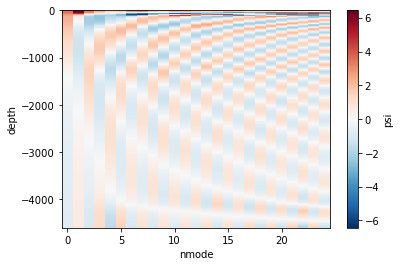

In [6]:
ds.psi.plot(x='nmode', y='depth')

In [7]:
import math as m
def plot_tensors(tensor: np.ndarray):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), tight_layout=True)
    nmodes = tensor.shape[0]
    ks = []
    for i in range(4):
        ax =np.ravel(axs)[i]
        k = (i+1) * m.floor(nmodes / 4)
        plot = ax.pcolormesh(tensor[k, :, :])
        fig.colorbar(plot, ax=ax)
        ax.set_title('Modenumber ' + str(k))

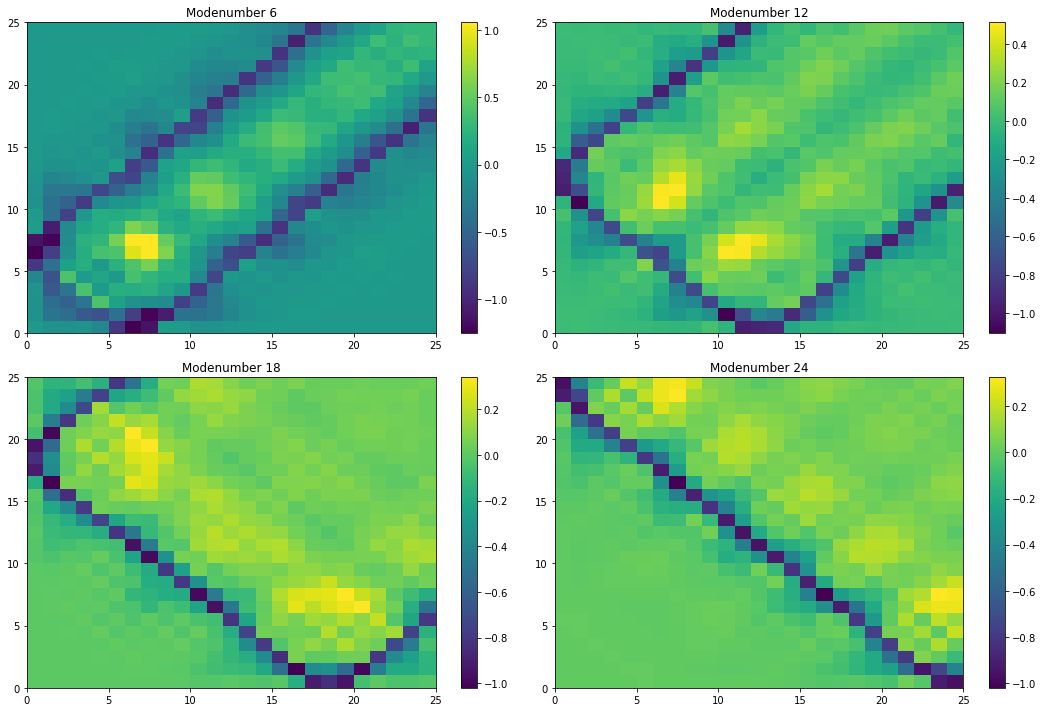

In [8]:
plot_tensors(multimode_params.Q)

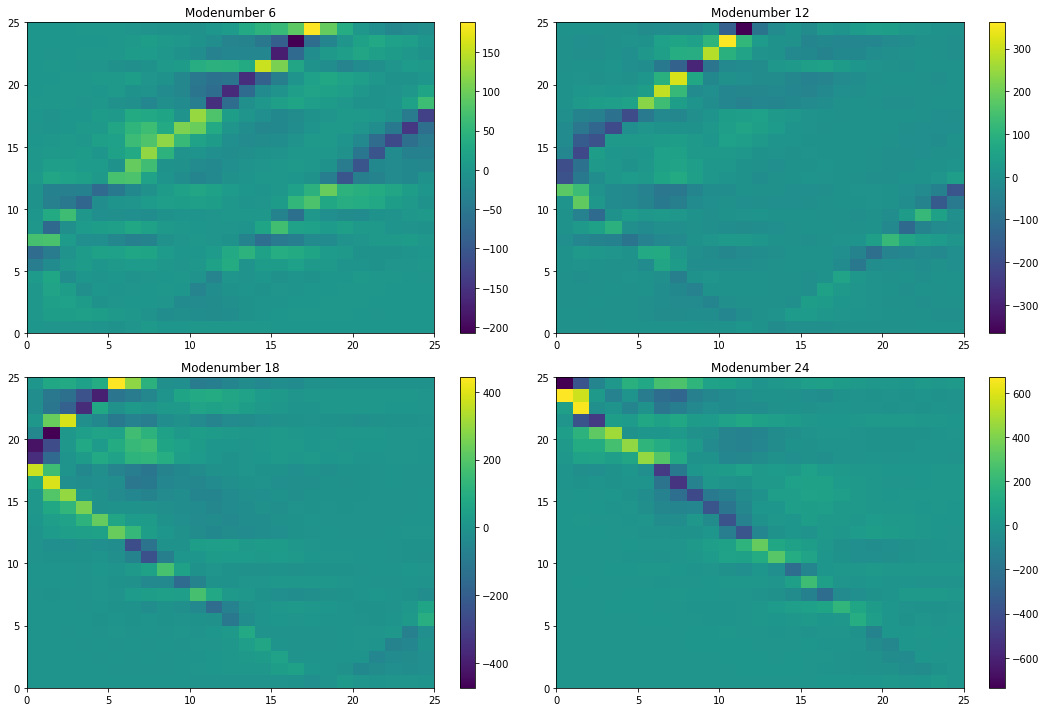

In [9]:
plot_tensors(multimode_params.R)

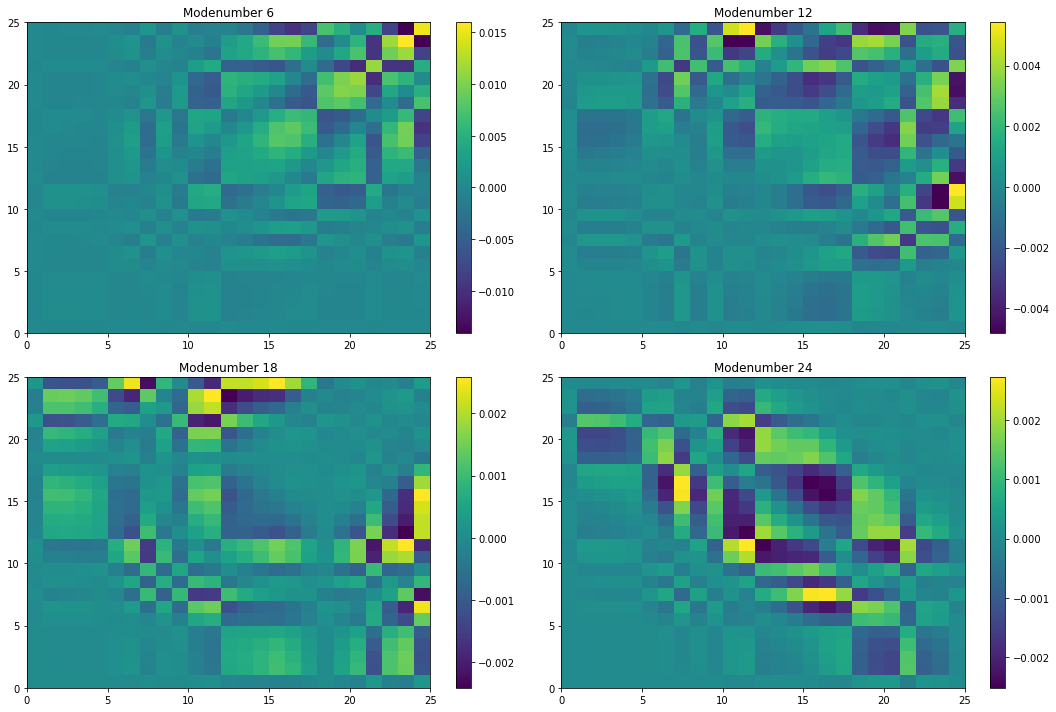

In [10]:
plot_tensors(multimode_params.S)

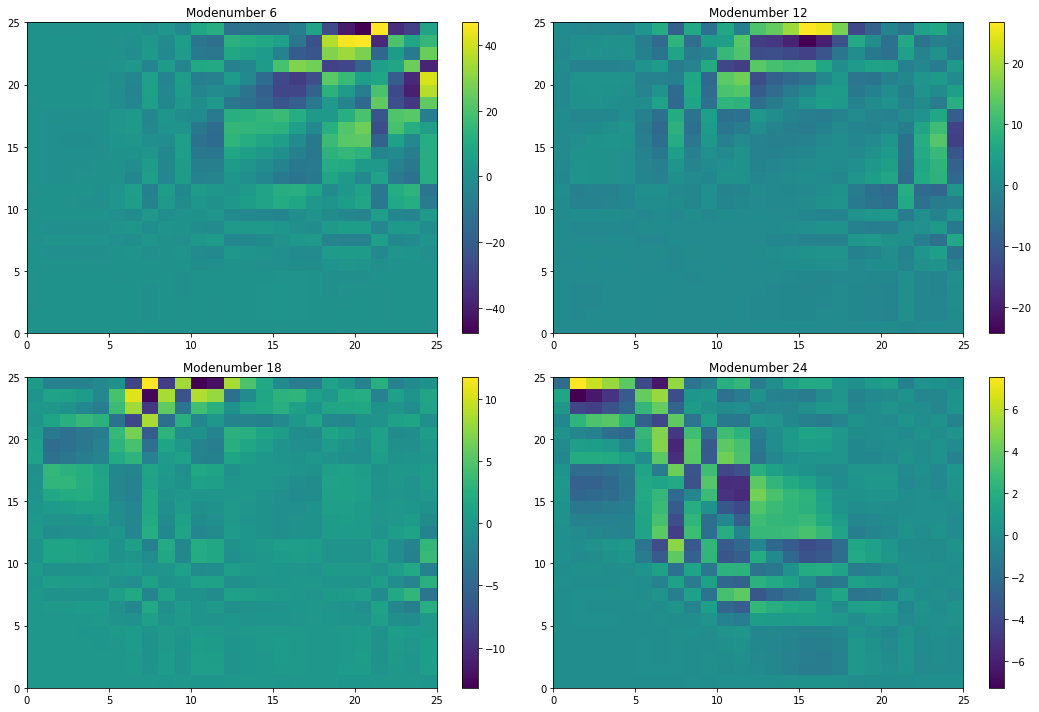

In [11]:
plot_tensors(multimode_params.T)

In [12]:
H =abs(depth[0] - depth[-1])
A = 1.33e-7 / H
gamma = A / ds.c.values**2
multimode_params.gamma = gamma

In [13]:
def tau(x, y):
    """"Wind field according to Mccreary (1980)."""
    delta_x = abs(x[0, 0] - x[0, -1]) / 2
    delta_y = abs(y[0, 0] - y[-1, 0]) / 2

    wind_x = np.cos(np.pi * x / delta_x)
    wind_x[abs(x) > delta_x / 2] = 0

    wind_y = (1 + y**2 / delta_y**2) * np.exp( - y**2 / delta_y**2)

    return -5e-6 * wind_x * wind_y

In [14]:
# from multimodemodel import Parameters, f_on_sphere
# params = []
# for i in range(multimode_params.nmodes):
#     params.append(
#         Parameters(
#             coriolis_func=f_on_sphere(omega=7.272205e-05),
#             on_grid=c_grid,
#             H=np.array([ds.H.values[i]]),
#             gamma = np.array([gamma[i]]),
#         )
#     )

In [15]:
from multimodemodel import (
    State, Variable,
 )

tau_x = np.empty(c_grid.u.shape)
for k in range(nmodes):
    tau_x[k, :, :] = tau(c_grid.u.x, c_grid.u.y) * ds.psi.values[0, k]
tau_x *= 1000

def zonal_wind(state, params):
    return State(u=Variable(tau_x /  params.rho_0 / H, c_grid.u, np.datetime64("NaT")));

In [16]:
import functools as ft
import operator as op
from multimodemodel import (
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_eta, linear_damping_u,
    linear_damping_v, advection_density,
    advection_momentum_u, advection_momentum_v,
)

terms = [
    pressure_gradient_i, pressure_gradient_j,
    coriolis_i, coriolis_j,
    divergence_i, divergence_j,
    laplacian_mixing_u, laplacian_mixing_v,
    linear_damping_u, linear_damping_v,
    linear_damping_eta, advection_density,
    advection_momentum_u, advection_momentum_v,
    zonal_wind
]

def rhs(state, params):
    w = (divergence_j(state, params) + divergence_i(state, params)).eta.safe_data
    state.set_diagnostic_variable(w=Variable(w, c_grid.eta, state.eta.time))
    return ft.reduce(op.add, (term(state, params) for term in terms))

In [17]:
def save_as_Dataset(state: State, params: MultimodeParameters):
    ds = state.variables["u"].as_dataarray.to_dataset(name='u_tilde')
    ds['v_tilde'] = state.variables["v"].as_dataarray
    ds['h_tilde'] = state.variables["eta"].as_dataarray
    x = (["j", "i"], (state.u.grid.x + state.v.grid.x) / 2)
    y = (["j", "i"], (state.u.grid.y + state.v.grid.y) / 2)
    ds.assign_coords({"x": x, "y": y})
    return ds

In [18]:
from multimodemodel import integrate, adams_bashforth3

time = 2 * 30 * 24 * 3600.  # 1 year
step = c_grid.u.dx.min() / ds.c.values[1:].max() / 10.
t0 = np.datetime64("2000-01-01")

In [19]:
def run(params, step, time):
    model_run = integrate(
        State(
            u=Variable(None, c_grid.u, t0),
            v=Variable(None, c_grid.v, t0),
            eta=Variable(None, c_grid.eta, t0),
            q=Variable(None, c_grid.q, t0)
        ),
        params,
        RHS=rhs,
        scheme=adams_bashforth3,
        step=step,
        time=time,
    )
    
    Nt = time // step

    output = []

    tolerance = 10.
    for i, next_state in enumerate(model_run):
        if i % (Nt // 5) == 0:
            output.append(save_as_Dataset(next_state, params))
        if np.nanmax(abs(next_state.variables["u"].safe_data)) > tolerance:
            output.append(save_as_Dataset(next_state, params))
            tolerance += 1.
        if tolerance > 20.:
            return xr.combine_by_coords(output)
    
    
    return xr.combine_by_coords(output)

In [20]:
# from multiprocessing import Pool

# pool = Pool()
# out = pool.map(run, params)

In [21]:

out = run(multimode_params, step=step, time=time)

In [22]:
out = out.rename({'z':'nmode'})

In [23]:
out['u'] = xr.dot(ds.psi, out.u_tilde)
out['v'] = xr.dot(ds.psi, out.v_tilde)
out['h'] = xr.dot(ds.psi, out.h_tilde)

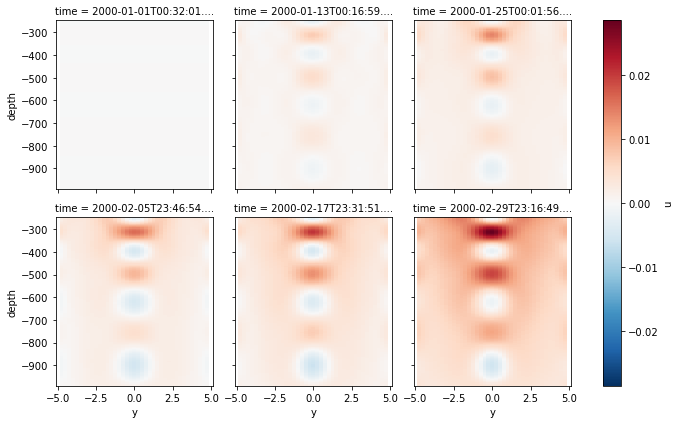

In [33]:
out.u.isel(i = 200, depth = slice(50,200)).plot.pcolormesh(x='y', y='depth', cmap='RdBu_r', col="time", col_wrap=3);

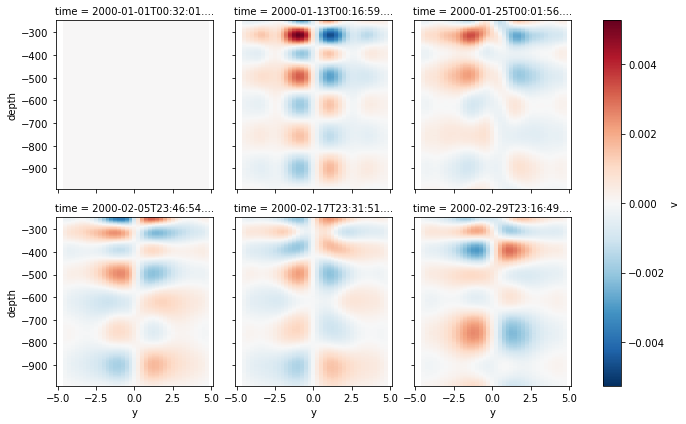

In [34]:
out.v.isel(i = 200, depth = slice(50,200)).plot.pcolormesh(x='y', y='depth', cmap='RdBu_r', col="time", col_wrap=3);